Felipe Bartelt de Assis Pessoa - 2016026841


# RBFs Aleatórias

Primeiramente, redefiniu-se as funções criadas no exercício passado para treinamento e avaliação de RBFs com k-médias, que tiveram pequenas modificações devido à divergência nos métodos por causa de valores numéricos pequenos, além das funções de remoção e normalização de dados de entrada e avaliação de acurácia:

In [38]:
def h_rbf(x, centers, cov_mat):
    m = x.shape[0]
    dist = x - centers
    
    if cov_mat.ndim < 2:
        cov_mat = np.eye(m) * cov_mat
    
    norm_factor = 1/np.sqrt((2*np.pi)**m * np.linalg.det(cov_mat))
    h = norm_factor * np.exp(-0.5 * dist @ np.linalg.inv(cov_mat) @ dist.T)

    return h

def train_RBF(x_train, y_train, hidden_dim, indep = False):
    km = KMeans(hidden_dim).fit(x_train)
    centers = km.cluster_centers_
    cov_list = []
    N = x_train.shape[0]
    m = x_train.shape[1]
    h = np.zeros((N, hidden_dim))

    for p in range(hidden_dim):
        p_samples = (km.labels_ == p).nonzero()
        
        if indep:
            cov_mat = np.diag(np.var(x_train[p_samples], axis=0)) + 0.001*np.diag(np.ones(m))
        else:
            cov_mat = np.cov(x_train[p_samples], rowvar=False) + 0.001*np.diag(np.ones(m))
        
        cov_list.append(np.copy(cov_mat))
        center = centers[p,:]
        h[:,p] = np.array([h_rbf(x_sample, centers[p], cov_mat) for x_sample in x_train])
    
    #h = np.nan_to_num(h)
    h_aug = np.append(np.ones((N, 1)), h, axis=1)
    #w, *_ = np.linalg.lstsq(h_aug, y_train)
    #w = np.nan_to_num(w)
    w = np.linalg.pinv(h_aug) @ y_train

    return (h, w, centers, cov_list)

def eval_RBF(x_test, rbf_params):
    w = rbf_params[1]
    hidden_dim = rbf_params[0].shape[1]
    centers = rbf_params[2]
    cov_list = rbf_params[3]
    N = x_test.shape[0]
    h = np.zeros((N, hidden_dim))
    
    for p in range(hidden_dim):
        cov_mat = np.copy(cov_list[p])
        h[:,p] = np.array([h_rbf(x_sample, centers[p], cov_mat) for x_sample in x_test])
    
    #h = np.nan_to_num(h)
    h = np.append(np.ones((N, 1)), h, axis=1)
    y_hat = h @ w
    
    return y_hat
    
def normalize_features(X, mean, std):
    Xtemp = np.copy(X)
    Xtemp = Xtemp - mean
    Xtemp = Xtemp / std
    return Xtemp

def delete_features(X, feat_idx):
    # Returns matrix X with features indexes in feat_idx ignored
    Xtemp = np.copy(X)
    Xtemp = np.delete(Xtemp, feat_idx,1)
    return Xtemp

def eval_accuracy(y_hat, y, nn_type = 0):
    # Divides quadratic error by 4 if activation function is tanh
    N = np.shape(y)[0] * (4 ** nn_type)
    return (1 - ((y-y_hat).T @ (y-y_hat)) / N).ravel()


Em seguida, definiu-se a função de *clustering* randômica com o seguinte intuito: dado um número desejado de clusters $i$, para cada *cluster* toma-se $i$ dados de entrada, aleatoriamente, então toma-se seu centro como a média desses $i$ dados de entrada. Defniu-se que cada *cluster* teria seu próprio raio, não necessariamente igual para todos, assim, esse foi definido como a média da variância, por linha, dos $i$ dados escolhidos. A função também classifica os dados de entrada com base distância euclidiana, sendo a classe igual ao número do *cluster*, cuja distância até o ponto é a menor. A função retorna os um vetor de centros `centers`, uma lista de raios `radii` e as classificações dos dados `y`. Seus parâmetros de entrada são os dados de entrada `X` e o número desejado de *clusters* `number`

In [5]:
def random_clustering(X, number):
    N = X.shape[0]
    rand_idx = np.arange(0,N)
    np.random.default_rng().shuffle(rand_idx)
    centers = []
    radii = []
    y = []

    for i in range(number):
        center = X[rand_idx[(i*number)%N:((i+1)*number)%N], :]
        centers.append(np.mean(center, axis=0))
        radii.append(np.mean(np.var(center, axis=1)))
    
    for sample in X:
        distance = np.sqrt(np.sum((sample - centers)**2, axis=1))
        label = np.argmin(distance)
        y.append(label)
    
    y = np.array(y)

    return np.array(centers), np.array(radii), y.reshape((-1,1))


Definiu-se assim, a função de treino para a RBF aleatória, análoga à primeira, porém, nesta não ocorre o cálculo das matrizes de covariância, uma vez que os raios foram definidos a priori.

In [6]:
def train_randRBF(x_train, y_train, hidden_dim):
    centers, radii, labels = random_clustering(x_train, hidden_dim)
    N = x_train.shape[0]
    h = np.zeros((N, hidden_dim))

    for p in range(hidden_dim):
        p_samples = (labels == p).nonzero()
        h[:,p] = np.array([h_rbf(x_sample, centers[p], radii[p]) for x_sample in x_train])
    
    h = np.nan_to_num(h)
    h_aug = np.append(np.ones((N, 1)), h, axis=1)
    #w = np.linalg.pinv(h_aug) @ y_train
    w, *_ = np.linalg.lstsq(h_aug, y_train)
    w = np.nan_to_num(w)

    return (h, w, centers, radii)

## Breast Cancer

O primeiro banco de dados utilizado para a comparação das RBFs foi o *Breast Cancer*. Removeu-se novamente os dados de índice $[2,3,9,11,12,13,14,18,19,22,23]$ e os restantes foram normalizados.

In [6]:
import numpy as np
import plotly.graph_objects as go
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans

# Load dataset
breast_cancer = load_breast_cancer()
X_samples = breast_cancer['data']
y_sample = np.reshape(breast_cancer['target'], (-1,1))

ignored_idx = [2,3,9,11,12,13,14,18,19,22,23]
X = delete_features(X_samples, ignored_idx)
X_mean = np.mean(X, axis = 0)
X_std = np.std(X, axis = 0)
X = normalize_features(X, X_mean, X_std)


Alterou-se os valores nulos de saída pra valores $-1$ e separou-se os dados, aleatoriamente, em $70\%$ para treinamento e $30\%$ para teste, sendo que foi visado a obtenção da mesma porcentagem para dados de cada saída diferente

In [7]:
y_sample[y_sample==0] = -1
N = X.shape[0]

# Get indexes corresponding to each class
idx1 = [idx for idx, val in enumerate(y_sample.flatten()) if val==1]
idx0 = sorted(list(set(range(0,N)) - set(idx1)))
N0,N1 = len(idx0), len(idx1)
N_train0, N_train1 = round(0.7*N0), round(0.7*N1)
# Randomize indexes
np.random.default_rng().shuffle(idx0)
np.random.default_rng().shuffle(idx1)

# Select samples for training and testing
x_train = X[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
x_test = X[np.append(idx0[N_train0::], idx1[N_train1::]),:]
y_train = y_sample[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
y_test = y_sample[np.append(idx0[N_train0::], idx1[N_train1::]),:]


Treinou-se então tanto a rede RBF baseada no k-médias quanto a RBF aleatória para número de neurônios no intervalo $[1,30)$, iterando-se 50 vezes para cada valor. Armazenou-se as médias e desvio padrão das acurácias de teste e treinamento de ambas as redes em listas de tuplas:

In [ ]:
acc_list_test, acc_rnd_list_test, acc_list_train, acc_rnd_list_train = [], [], [], []
for p in range(1, 30):
    
    acc_train, acc_test, acc_rnd_train, acc_rnd_test = [], [], [], []
    for _ in range(50):
        rbf = train_RBF(x_train, y_train, p)
        y_hat_train = np.sign(eval_RBF(x_train, rbf))
        y_hat_test = np.sign(eval_RBF(x_test, rbf))
        acc_train.append(eval_accuracy(y_hat_train, y_train, 1))
        acc_test.append(eval_accuracy(y_hat_test, y_test, 1))

        rand_rbf = train_randRBF(x_train, y_train, p)
        y_hat_rnd_train = np.sign(eval_RBF(x_train, rand_rbf))
        y_hat_rnd_test = np.sign(eval_RBF(x_test, rand_rbf))
        acc_rnd_train.append(eval_accuracy(y_hat_rnd_train, y_train, 1)) 
        acc_rnd_test.append(eval_accuracy(y_hat_rnd_test, y_test, 1))

    acc_list_test.append((np.mean(acc_train), np.std(acc_train)))
    acc_rnd_list_test.append((np.mean(acc_test), np.std(acc_test)))
    acc_list_train.append((np.mean(acc_rnd_train), np.std(acc_rnd_train)))
    acc_rnd_list_train.append((np.mean(acc_rnd_test), np.std(acc_rnd_test)))


Com os valores obtidos, plotou-se o seguinte gráfico:

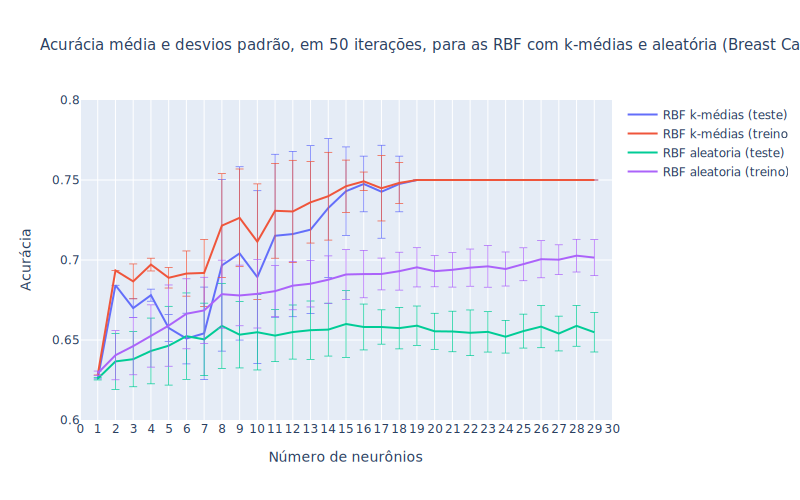

In [89]:
rbf_test = list(zip(*acc_rnd_list_test))
rbf_train = list(zip(*acc_list_test))
rbf_rnd_test = list(zip(*acc_rnd_list_train))
rbf_rnd_train = list(zip(*acc_list_train))

fig = go.Figure(go.Scatter(x = np.arange(1,30), y=rbf_test[0], error_y=dict(type='data', array=rbf_test[1],visible=True, thickness=0.7), name = 'RBF k-médias (teste)'))
fig.add_trace(go.Scatter(x = np.arange(1,30), y=rbf_train[0], error_y=dict(type='data', array=rbf_train[1],visible=True, thickness=0.7), name = 'RBF k-médias (treino)'))
fig.add_trace(go.Scatter(x = np.arange(1,30), y=rbf_rnd_test[0], error_y=dict(type='data', array=rbf_rnd_test[1],visible=True, thickness=0.7), name = 'RBF aleatoria (teste)'))
fig.add_trace(go.Scatter(x = np.arange(1,30), y=rbf_rnd_train[0], error_y=dict(type='data', array=rbf_rnd_train[1],visible=True, thickness=0.7), name = 'RBF aleatoria (treino)'))
fig.update_xaxes(range = [0,30], dtick=1, title= 'Número de neurônios')
fig.update_yaxes(range = [0.6, 0.8], title= 'Acurácia')
fig.update_layout(title = {'text':'Acurácia média e desvios padrão, em 50 iterações, para as RBF com k-médias e aleatória (Breast Cancer)', 'font_size':15}, width=800, height=500)
fig.show(renderer = 'svg', width =800, height = 500)


Nota-se que a RBF com k-médias convergiu para uma acurácia de 75%, tanto em treinamento quanto em teste, o que é inesperado e indica um erro de implementação, este infelizmente não foi encontrado, mas com certeza ocorre no treinamento dessa RBF. De toda forma, é notável que o comportamento da RBF aleatória é longe do ideal, convergindo lentamente para melhores acurácias, tanto para treinamento quanto para teste.

Iterou-se novamente as redes, dessa vez somente 3 iterações, devido ao custo computacional, para os números de neurônios 50, 100 e 300, valores esses que foram usados para avaliação das ELMs.

In [ ]:
acc_list_test, acc_rnd_list_test, acc_list_train, acc_rnd_list_train = [], [], [], []
hyper_params = [50, 100, 300]
for p in hyper_params:
    acc_train, acc_test, acc_rnd_train, acc_rnd_test = [], [], [], []
    
    for _ in range(3):
        rbf = train_RBF(x_train, y_train, p)
        y_hat_train = np.sign(eval_RBF(x_train, rbf))
        y_hat_test = np.sign(eval_RBF(x_test, rbf))
        acc_train.append(eval_accuracy(y_hat_train, y_train, 1))
        acc_test.append(eval_accuracy(y_hat_test, y_test, 1))

        rand_rbf = train_randRBF(x_train, y_train, p)
        y_hat_rnd_train = np.sign(eval_RBF(x_train, rand_rbf))
        y_hat_rnd_test = np.sign(eval_RBF(x_test, rand_rbf))
        acc_rnd_train.append(eval_accuracy(y_hat_rnd_train, y_train, 1)) 
        acc_rnd_test.append(eval_accuracy(y_hat_rnd_test, y_test, 1))

    acc_list_test.append((np.mean(acc_test), np.std(acc_test)))
    acc_rnd_list_test.append((np.mean(y_hat_rnd_test), np.std(y_hat_rnd_test)))
    acc_list_train.append((np.mean(acc_train), np.std(acc_train)))
    acc_rnd_list_train.append((np.mean(y_hat_rnd_train), np.std(y_hat_rnd_train)))

In [107]:
print('\t\t RBF k-médias')
print('_'*60)
print('hiperparametro: \t\ttraining accuracy:')
for i,j in zip(hyper_params, acc_list_train):
    print('\t',i,'\t',j[0],'±',j[1])
print('\nhiperparametro: \t\ttest accuracy:')
for i,j in zip(hyper_params, acc_list_test):
    print('\t',i,'\t',j[0],'±',j[1])
print('\n\n\t\t RBF aleatória')
print('_'*60)
print('hiperparametro: \t\ttraining accuracy:')
for i,j in zip(hyper_params, acc_rnd_list_train):
    print('\t',i,'\t',j[0],'±',j[1])
print('\nhiperparametro: \t\ttest accuracy:')
for i,j in zip(hyper_params, acc_rnd_list_test):
    print('\t',i,'\t',j[0],'±',j[1])



		 RBF k-médias
____________________________________________________________
hiperparametro: 		training accuracy:
	 50 	 0.9430485762144053 ± 0.0065946464606463934
	 100 	 0.9639865996649917 ± 0.0023688669386484106
	 300 	 0.990787269681742 ± 0.0023688669386484106

hiperparametro: 		test accuracy:
	 50 	 0.5165692007797271 ± 0.0841148109566917
	 100 	 0.543859649122807 ± 0.11578356651007796
	 300 	 0.5419103313840156 ± 0.11854031809365126


		 RBF aleatória
____________________________________________________________
hiperparametro: 		training accuracy:
	 50 	 0.7989949748743719 ± 0.6013377005689082
	 100 	 0.8090452261306532 ± 0.5877463926517967
	 300 	 0.8341708542713567 ± 0.551506106842159

hiperparametro: 		test accuracy:
	 50 	 0.8830409356725146 ± 0.4692959683681609
	 100 	 0.8713450292397661 ± 0.49067080616147435
	 300 	 0.9064327485380117 ± 0.4223501774331646



Nota-se que a acurácia da RBF com k-médias piorou muito, apesar de ter obtido uma acurácia de treino maior. A rede aleatória, apesar de ser considerado poucas iterações, se mostrou boa para 300 neurônios. Assim, assume-se, uma vez que foram feitas poucas iterações, que para número de neurônios entre 50 e 100 para a rede aleatória tem comportamento tão bom quanto a rede com k-médias utilizando 19 neurônios. Supondo-se que a rede RBF com k-médias esteja implementada corretamente, pode-se afirmar que o resultado das ELMs foi superior, uma vez que essa obteve acurácia de 88% para apenas 5 neurônios.

## Statlog (Heart)

A base de dados seguinte foi a Statlog (Heart). Os dados foram normalizados, assim como os dados de índice 4 e 5 foram removidos.

In [12]:
import numpy as np
import plotly.graph_objects as go
from sklearn.datasets import load_breast_cancer
from sklearn.cluster import KMeans

data = np.loadtxt( 'heart.dat' )
X_samples = np.copy(data[:, 0:-1])
y_sample = np.reshape(np.copy(data[:, -1]), (-1,1))
ignored_idx = [4,5]

X = delete_features(X_samples, ignored_idx)
X_mean = np.mean(X, axis = 0)
X_std = np.std(X, axis = 0)
X = normalize_features(X, X_mean, X_std)


Da mesma forma, alterou-se os valores de saída iguais a $2$ para valores $-1$ e separou-se o conjunto de treinamento e teste da mesma forma.

In [13]:
y_sample[y_sample==2] = -1
N = X.shape[0]

# Get indexes corresponding to each class
idx1 = [idx for idx, val in enumerate(y_sample.flatten()) if val==1]
idx0 = sorted(list(set(range(0,N)) - set(idx1)))
N0,N1 = len(idx0), len(idx1)
N_train0, N_train1 = round(0.7*N0), round(0.7*N1)
# Randomize indexes
np.random.default_rng().shuffle(idx0)
np.random.default_rng().shuffle(idx1)

# Select samples for training and testing
x_train = X[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
x_test = X[np.append(idx0[N_train0::], idx1[N_train1::]),:]
y_train = y_sample[np.append(idx0[0:N_train0], idx1[0:N_train1]),:]
y_test = y_sample[np.append(idx0[N_train0::], idx1[N_train1::]),:]


Treinou-se ambas as redes para os mesmos números de neurônios entre $[1,30)$, também com $50$ iterações, armazenando-se as acurácias médias e desvio padrão de ambas as redes sobre os conjuntos de treinamento e teste.

In [14]:
acc_list_test, acc_rnd_list_test, acc_list_train, acc_rnd_list_train = [], [], [], []
for p in range(1, 30):
    #print(p)
    acc_train, acc_test, acc_rnd_train, acc_rnd_test = [], [], [], []
    for _ in range(50):
        rbf = train_RBF(x_train, y_train, p)
        y_hat_train = np.sign(eval_RBF(x_train, rbf))
        y_hat_test = np.sign(eval_RBF(x_test, rbf))
        acc_train.append(eval_accuracy(y_hat_train, y_train, 1))
        acc_test.append(eval_accuracy(y_hat_test, y_test, 1))

        rand_rbf = train_randRBF(x_train, y_train, p)
        y_hat_rnd_train = np.sign(eval_RBF(x_train, rand_rbf))
        y_hat_rnd_test = np.sign(eval_RBF(x_test, rand_rbf))
        acc_rnd_train.append(eval_accuracy(y_hat_rnd_train, y_train, 1)) 
        acc_rnd_test.append(eval_accuracy(y_hat_rnd_test, y_test, 1))

    acc_list_test.append((np.mean(acc_test), np.std(acc_test)))
    acc_rnd_list_test.append((np.mean(acc_rnd_test), np.std(acc_rnd_test)))
    acc_list_train.append((np.mean(acc_train), np.std(acc_train)))
    acc_rnd_list_train.append((np.mean(acc_rnd_train), np.std(acc_rnd_train)))


Com os valores obtidos, plotou-se o seguinte gráfico:

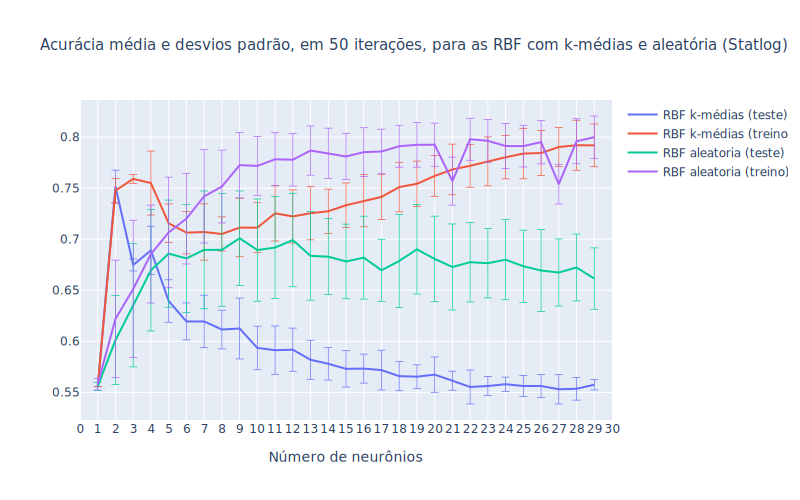

In [19]:
rbf_test = list(zip(*acc_list_test))
rbf_train = list(zip(*acc_list_train))
rbf_rnd_test = list(zip(*acc_rnd_list_test))
rbf_rnd_train = list(zip(*acc_rnd_list_train))

fig = go.Figure(go.Scatter(x = np.arange(1,30), y=rbf_test[0], error_y=dict(type='data', array=rbf_test[1],visible=True, thickness=0.7), name = 'RBF k-médias (teste)'))
fig.add_trace(go.Scatter(x = np.arange(1,30), y=rbf_train[0], error_y=dict(type='data', array=rbf_train[1],visible=True, thickness=0.7), name = 'RBF k-médias (treino)'))
fig.add_trace(go.Scatter(x = np.arange(1,30), y=rbf_rnd_test[0], error_y=dict(type='data', array=rbf_rnd_test[1],visible=True, thickness=0.7), name = 'RBF aleatoria (teste)'))
fig.add_trace(go.Scatter(x = np.arange(1,30), y=rbf_rnd_train[0], error_y=dict(type='data', array=rbf_rnd_train[1],visible=True, thickness=0.7), name = 'RBF aleatoria (treino)'))
fig.update_xaxes(range = [0,30], dtick=1, title= 'Número de neurônios')
#fig.update_yaxes(range = [0.6, 0.8], title= 'Acurácia')
fig.update_layout(title = {'text':'Acurácia média e desvios padrão, em 50 iterações, para as RBF com k-médias e aleatória (Statlog)', 'font_size':15}, width=800, height=500)
fig.show(renderer = 'svg', width =800, height = 500)


Desprezando-se o fato da rede RBF com k-médias estar claramente errada, nota-se que a rede aleatória teve comportamento muito melhor para essa base de dados. Tomando-se como correto pelo menos a acurácia obtida para a RBF com k-médias de 1 neurônio, observa-se que a rede aleatória não alcança os 75% de acurácia obtido pela outra. Além disso, ambas as redes novamente são inferiores às ELMs, que obteve 79% de acurácia para 10 neurônios.

Da mesma forma, iterou-se ambas as redes, com 3 iterações, para os valores de neurônio 50, 100 e 188. O valor de 300 não foi possível devido à limitação do k-médias, para o qual o número de *clusters* deve ser inferior ao número de amostras.

In [24]:
acc_list_test, acc_rnd_list_test, acc_list_train, acc_rnd_list_train = [], [], [], []
hyper_params = [50, 100, 188]
for p in hyper_params:
    acc_train, acc_test, acc_rnd_train, acc_rnd_test = [], [], [], []
    for _ in range(3):
        rbf = train_RBF(x_train, y_train, p)
        y_hat_train = np.sign(eval_RBF(x_train, rbf))
        y_hat_test = np.sign(eval_RBF(x_test, rbf))
        acc_train.append(eval_accuracy(y_hat_train, y_train, 1))
        acc_test.append(eval_accuracy(y_hat_test, y_test, 1))

        rand_rbf = train_randRBF(x_train, y_train, p)
        y_hat_rnd_train = np.sign(eval_RBF(x_train, rand_rbf))
        y_hat_rnd_test = np.sign(eval_RBF(x_test, rand_rbf))
        acc_rnd_train.append(eval_accuracy(y_hat_rnd_train, y_train, 1)) 
        acc_rnd_test.append(eval_accuracy(y_hat_rnd_test, y_test, 1))

    acc_list_test.append((np.mean(acc_test), np.std(acc_test)))
    acc_rnd_list_test.append((np.mean(y_hat_rnd_test), np.std(y_hat_rnd_test)))
    acc_list_train.append((np.mean(acc_train), np.std(acc_train)))
    acc_rnd_list_train.append((np.mean(y_hat_rnd_train), np.std(y_hat_rnd_train)))

In [25]:
print('\t\t RBF k-médias')
print('_'*60)
print('hiperparametro: \t\ttraining accuracy:')
for i,j in zip(hyper_params, acc_list_train):
    print('\t',i,'\t',j[0],'±',j[1])
print('\nhiperparametro: \t\ttest accuracy:')
for i,j in zip(hyper_params, acc_list_test):
    print('\t',i,'\t',j[0],'±',j[1])
print('\n\n\t\t RBF aleatória')
print('_'*60)
print('hiperparametro: \t\ttraining accuracy:')
for i,j in zip(hyper_params, acc_rnd_list_train):
    print('\t',i,'\t',j[0],'±',j[1])
print('\nhiperparametro: \t\ttest accuracy:')
for i,j in zip(hyper_params, acc_rnd_list_test):
    print('\t',i,'\t',j[0],'±',j[1])


		 RBF k-médias
____________________________________________________________
hiperparametro: 		training accuracy:
	 50 	 0.8465608465608465 ± 0.004320087729776328
	 100 	 0.9153439153439153 ± 0.004320087729776373
	 188 	 1.0 ± 0.0

hiperparametro: 		test accuracy:
	 50 	 0.5555555555555556 ± 0.0
	 100 	 0.5555555555555556 ± 0.0
	 188 	 0.4444444444444444 ± 0.0


		 RBF aleatória
____________________________________________________________
hiperparametro: 		training accuracy:
	 50 	 -0.026455026455026454 ± 0.9996500045392207
	 100 	 -0.06878306878306878 ± 0.9976316401602264
	 188 	 1.0 ± 0.0

hiperparametro: 		test accuracy:
	 50 	 -0.06172839506172839 ± 0.9980929842670487
	 100 	 -0.06172839506172839 ± 0.9980929842670487
	 188 	 1.0 ± 0.0


Por meio desses resultados, conclui-se com certeza de que as redes ELM tem melhor comportamento para ambas as bases estudadas. Reitera-se também que o erro de implementação das redes RBF com k-médias só foi percebido tardiamente, quando se decidiu realizar iterações para uma grande gama de neurônios e só foi confirmado mais ainda, após diversas tentativas de mudança de código, quando se estudou a base Statlog.